# Final Project: Multistage Edge Detection with Canny Algorithms
# Course: COSC 6349 - Computer Vision & Image Processing
# Professor: Dr. Hongyu Guo
# Student: Matthew Harper


# References
## [1] Guo, Hongyu. Computer Vision & Image Processing. COSC 6349 – Lecture Series 1-6.
## [2] Gonzalez, R. C., & Wintz, P. (2008). Digital image processing (3rd ed.). Addison-Wesley. 
## [3] Active Contours. (n.d.). MATLAB. https://www.mathworks.com/help/images/ref/activecontour.html
## [4] Canny, J. (1986). A computational approach to edge detection. IEEE Transactions on Pattern Analysis and Machine Intelligence, PAMI-8(6), 679–698. https://doi.org/10.1109/tpami.1986.4767851
## [5] Sahir, S. (n.d.). Canny Edge Detection step by step in Python — Computer Vision. https://medium.com/data-science/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123



# Read and Show Image in color orignal format

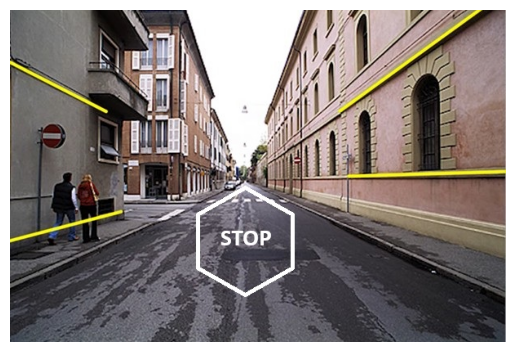

In [3]:
import matplotlib.pyplot  as plt
from matplotlib import image as mpimg
process_img= mpimg.imread("C:/Users/harpe/COSC 6349 Computer Vision Final Proj/street_picture_2.jpg")

plt.imshow(process_img)
plt.axis("off")
plt.show()

# Create Grayscale Image Example #1 Manual Iteration over images
Needs somem work and experimentation

In [4]:
import numpy as np

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2990 * r + 0.5870 * g + 0.1140 * b

    return gray

In [6]:
gray_image=rgb2gray(process_img)
print("shape:", gray_image.shape, "dtype:", gray_image.dtype)

shape: (407, 608) dtype: float64


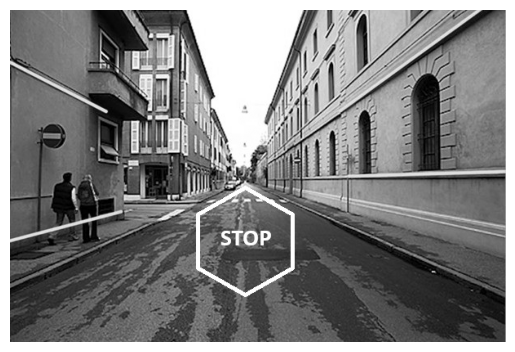

In [7]:
plt.imshow(gray_image, cmap='gray')
plt.imsave("gray_image.jpg", gray_image, cmap="gray")
plt.axis("off")
plt.show()

# Add Gaussian Noise with Convoltion

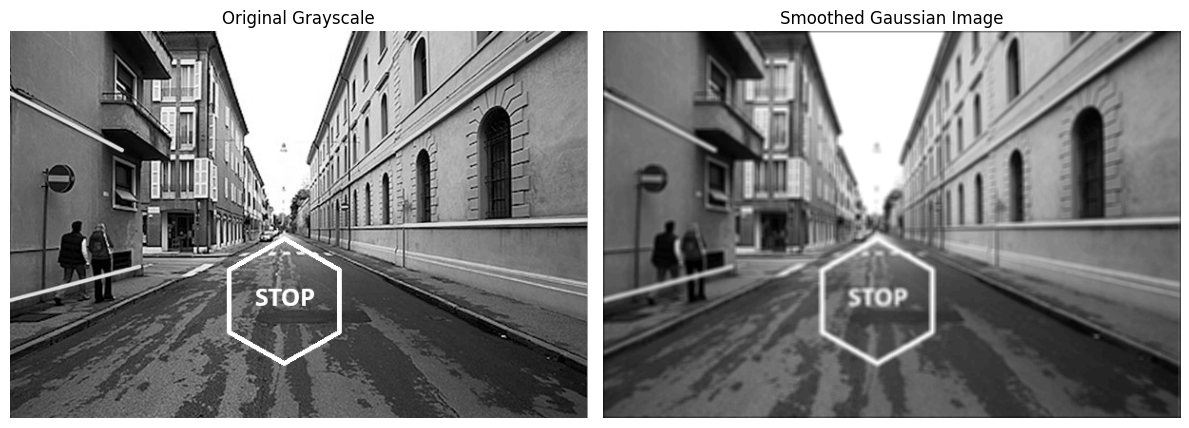

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#Define a 1D (1x5) Smoothing Gaussian filter
kernel = np.array([0.1, 0.1, .1, 0.1, 0.1], dtype=np.float32) #values can be adjusted based on image noise

#Assign the signal image from the pre-processed gray image
signal=gray_image 

# Convolve over the horizontal edge Gx
tmp = np.zeros_like(signal, dtype=np.float32) #create a zeros array same size as image
for y in range(signal.shape[0]): #convlolve over signal array and assign values to tmp array
    tmp[y, :] = np.convolve(signal[y, :], kernel, mode="same")

# Convolve over the vertical edge Gy
out = np.zeros_like(signal, dtype=np.float32)  #create a zeros array same size as image
for x in range(signal.shape[1]):#convlolve over tmp array and assign values to final output array
    out[:, x] = np.convolve(tmp[:, x], kernel, mode="same")

#Assign the output processed image as gray image 0-255 pixel magnitude
out = np.clip(out, 0, 255).astype(np.uint8)

#Plot both original and smoothed images for comparison

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Original Grayscale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(out, cmap="gray")
plt.title("Smoothed Gaussian Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Working 2d Convolution & Gradient Magnitude Using Sobel Kernels

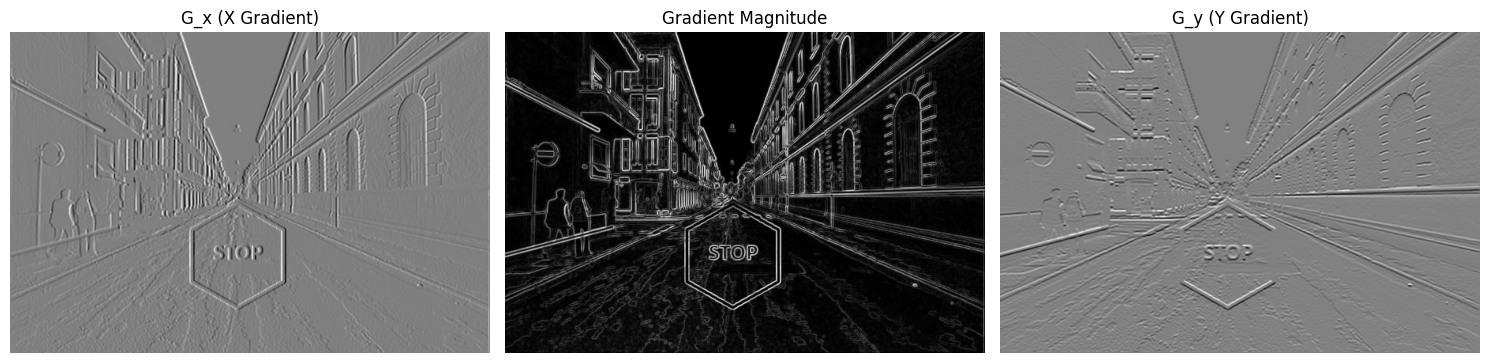

In [9]:
def convolve2d_manual(image, kernel):
    #determine the height and width of the image for padding
    #padding is needed for convolution window on sides of 
    #of image in which convolution window is [2k+1,2k+1]/2
    height, width = image.shape
    kernal_height, kernel_width = kernel.shape
    pad_h = kernal_height // 2
    pad_w = kernel_width // 2

    #Pad image with zeros
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    out = np.zeros((height, width), dtype=np.float32)
    
    #Convolve over image 
    for y in range(height):
        for x in range(width):
            region = padded[y:y+kernal_height, x:x+kernel_width]
            out[y, x] = np.sum(region * kernel)

    return out

def gradient_magnitude_sobel_operators(image):
    image = image.astype(np.float32)

    # Sobel kernels from Digital Image Processing 3rd.ed.
    #Gonzalez, R. C., & Wintz, P. (2008). Digital image processing (3rd ed.). Addison-Wesley. 
    #Page 166 3.6.4 Using First-Order Derivatives for Image Sharpening - The Gradient & Sobel Operators
    
    kernel_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype=np.float32)

    kernel_y = np.array([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ], dtype=np.float32)

    Gx = convolve2d_manual(image, kernel_x)
    Gy = convolve2d_manual(image, kernel_y)

    gradient_magnitude = np.sqrt(np.square(Gx) + np.square(Gy))
    
    return gradient_magnitude, Gx, Gy

magnitude, Gx, Gy = gradient_magnitude_sobel_operators(signal)

#Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#plot(magnitude, gx, gy)
axes[0].imshow(Gx, cmap='gray')
axes[0].set_title('G_x (X Gradient)')
axes[0].axis('off')

axes[1].imshow(magnitude, cmap='gray')
axes[1].set_title('Gradient Magnitude')
axes[1].axis('off')

axes[2].imshow(Gy, cmap='gray')
axes[2].set_title('G_y (Y Gradient)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Now calculate Gradient Direction Angle and Apply to Image for Non-Max Suppresion

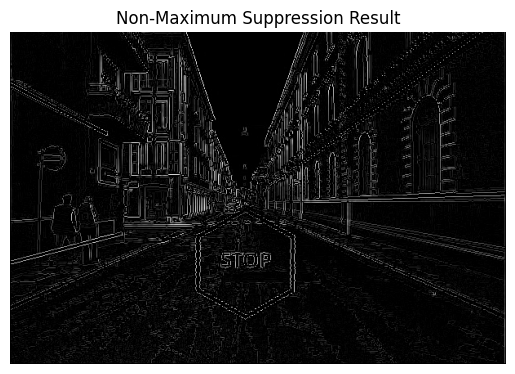

In [10]:
theta = np.arctan2(Gy, Gx)     
    
angle = (np.degrees(theta) +180) % 180.0 #convert to angle
    

def nms_non_max_suppression(magnitude, angle): #magnitude and angle
    height, weight = magnitude.shape
    out = np.zeros((height, weight), dtype=np.float32)
    
    for y in range(1, height-1):
        for x in range(1, weight-1):
            a = angle[y, x]

            # Quantize to 4 directions
            if (0 <= a < 22.5) or (157.5 <= a < 180):
                m1, m2 = magnitude[y, x-1], magnitude[y, x+1]          # 0°
            elif 22.5 <= a < 67.5:
                m1, m2 = magnitude[y-1, x+1], magnitude[y+1, x-1]      # 45°
            elif 67.5 <= a < 112.5:
                m1, m2 = magnitude[y-1, x], magnitude[y+1, x]          # 90°
            else:
                m1, m2 = magnitude[y-1, x-1], magnitude[y+1, x+1]      # 135°

            out[y, x] = magnitude[y, x] if (magnitude[y, x] >= m1 and magnitude[y, x] >= m2) else 0.0

    return out

non_max_suppresed_img = nms_non_max_suppression(magnitude, angle)

plt.imshow(non_max_suppresed_img, cmap="gray")
plt.title("Non-Maximum Suppression Result")
plt.axis("off")
plt.show()

# Now Apply High and Low Pixel Edge Threshold to Filter out non significant edges and noise

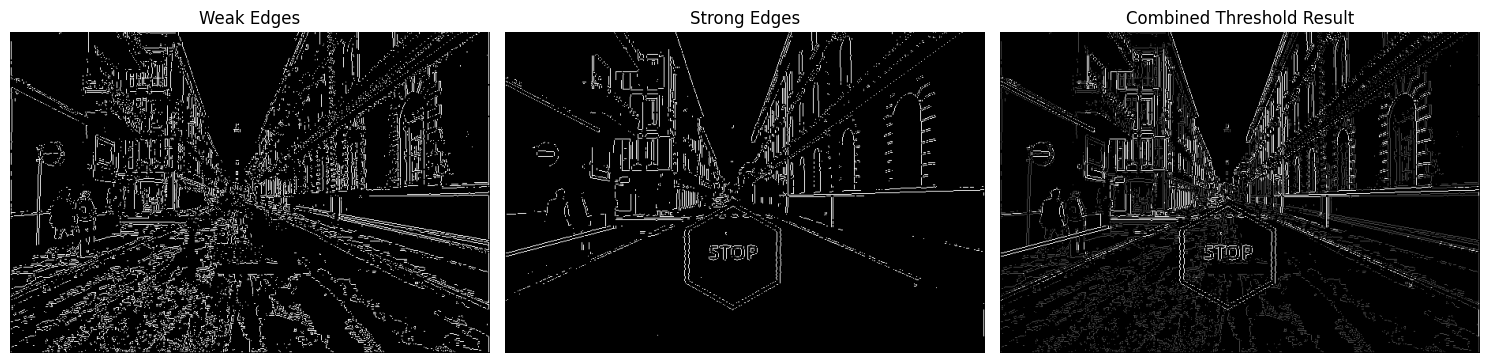

In [19]:
def threshold(nonmax_imgage, low_thresh, high_thresh):
    
    #threshold to an Non-Maximum Suppression image from previous step
    #lowThreshold  : ratio for weak edges
    #highThreshold : ratio for strong edges
   
    height, width = nonmax_imgage.shape #MxN shape of matrix
    #create zeros matrix for storing weak and strong edges
    img = np.zeros((height, width), dtype=np.uint8)

    # Filter values for strong/weak edge detection
    weak = np.uint8(75)
    strong = np.uint8(250)

    # Identify strong, weak, and non-edge pixels
    strong_i, strong_j = np.where(nonmax_imgage>= high_thresh)
    weak_i, weak_j = np.where((nonmax_imgage >= low_thresh) & (nonmax_imgage < high_thresh))

    img[strong_i, strong_j] = strong
    img[weak_i, weak_j] = weak

    return img, weak, strong

#return threshold image with weak and strong edge array values can be adjusted 
#Canny recommended values of 2-3:1 (high-low) - using .10-.30 or 3:1
thresh_img, weak, strong = threshold(non_max_suppresed_img,100,400)

#Create black (black=0) images for each threshold processed image for comparison
weak_img = np.zeros_like(thresh_img, dtype=np.uint8)
strong_img = np.zeros_like(thresh_img, dtype=np.uint8)

#copy weak edges from array to weak image
weak_img[thresh_img == weak] = weak
#copy strong edges from array to strong images
strong_img[thresh_img == strong] = strong

#plot image outputs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(weak_img, cmap="gray")
plt.title("Weak Edges")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(strong_img, cmap="gray")
plt.title("Strong Edges")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(thresh_img, cmap="gray")
plt.title("Combined Threshold Result")
plt.axis("off")

plt.tight_layout()
plt.show()